In [44]:
from dotenv import load_dotenv
from nltk.tokenize.api import StringTokenizer

load_dotenv()

True

In [45]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = InMemoryVectorStore(embeddings)

### Indexing

In [46]:
# Loading documents

import bs4
from langchain_community.document_loaders import WebBaseLoader, SQLDatabaseLoader

bs4_strainer = bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(parse_only=bs4_strainer)
)

docs = loader.load()
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [47]:
# Splitting documents

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1_000,
    chunk_overlap=200,
    add_start_index=True
)
all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [48]:
# Storing documents

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['0df298d0-92fc-4fed-9f58-c7d4b1b33ed5', '58f2a391-d035-4ff0-8c62-fc6590ab8c7c', '346e3754-6dc6-4966-9321-189576475e73']


### Retrieval and Generation

In [59]:
from langchain import hub

# using rag prompt from hub
prompt = hub.pull("rlm/rag-prompt")

# custom prompt
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always using Korean.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [70]:
from typing_extensions import List, TypedDict, Annotated
from langchain_core.documents import Document
from typing import Literal
from langchain_core.tools import tool


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]


# State
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


# Nodes
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        f"Source: {doc.metadata}\n" f"Content: {doc.page_content}"
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [61]:
# Control flow

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

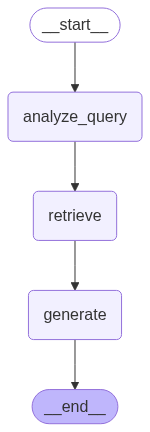

In [52]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
# Usage

result = graph.invoke({"question": "Decomposition Task가 뭐야?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='3279885d-2ceb-4cfa-8d91-c502a9343ea2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsour

In [66]:
# Stream steps

for step in graph.stream({"question": "Decomposition Task가 뭐야?"}, stream_mode="updates"):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Decomposition Task', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='3279885d-2ceb-4cfa-8d91-c502a9343ea2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Dom

### Query analysis

In [67]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [68]:
# Stream steps

for step in graph.stream({"question": "작업 분해(Task Decomposition)에 대해 게시물 끝부분에서 무엇이라고 말하고 있어?"}, stream_mode="updates"):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': '작업 분해(Task Decomposition)', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='df6b768d-621b-42d1-a045-2d9349e458e3', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 31986, 'section': 'end'}, page_content='},\n  {\n    "role": "user",\n    "content": "{{There are 10 levels in total. The main character is a plumber named Mario, who can walk and jump. It is a classical platform game just like Super Mario. The main character moves from left to right, trying to get to the destination, where there are many obstacles and attacks from enemies in the process.}}\\n\\nIs anything else unclear? If yes, only answer in the form:\\n{remaining unclear areas} remaining questions.\\n{Next question}\\nIf everything is sufficiently clear, only answer \\"Nothing more to clarify.\\"."\n  },\n  {\n    "role": "assistant",\n    "content": "Remaining unclear areas: 2 remaining questions.\\nCan you prov

### Chains

In [84]:
from langgraph.graph import MessagesState, StateGraph
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(MessagesState)


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise. Always using Korean."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
           or (message.type == "ai" and not message.tool_calls)
    ]
    chain_prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(chain_prompt)
    return {"messages": [response]}

In [85]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

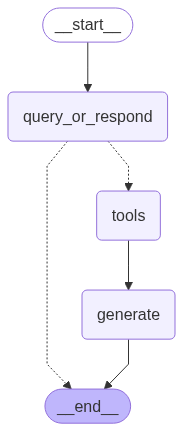

In [86]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [88]:
input_message = "안녕"

for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

안녕
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


In [89]:
input_message = "Task Decomposition가 뭐야?"

for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Task Decomposition가 뭐야?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_nLwfGqdllvvC8SMBWGZ3RTrF)
 Call ID: call_nLwfGqdllvvC8SMBWGZ3RTrF
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (

In [90]:
# Stateful management of chat history

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "woopaca"}}

In [94]:
input_message = "Task Decomposition가 뭐야?"
for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
):
    step["messages"][-1].pretty_print()

# -----

input_message = "그걸 사용하는 일반적인 방법들 좀 찾아줄 수 있어?"
for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Task Decomposition가 뭐야?
================================== Ai Message ==================================

Task Decomposition은 복잡한 작업이나 문제를 더 작고 간단한 하위 작업으로 나누는 과정입니다. 이 기법은 특히 인공지능 분야에서 효율적으로 문제를 해결하고 계획을 세우는 데 자주 사용됩니다.

### 주요 특징

1. **단계별 접근**: 큰 과제를 여러 개의 작은 단계로 나누어 각 단계에서 수행해야 할 작업을 명확히 합니다.

2. **모델의 사고 추적**: Chain of Thought (CoT)와 같은 기법을 활용하여, 모델이 "단계별로 생각"하도록 지시함으로써 복잡한 문제를 더 쉽게 해결할 수 있도록 합니다.

3. **다양한 방법론**:
   - **프롬프트 사용**: "XYZ를 위한 단계는 무엇인가?"와 같은 질문을 통해 하위 목표를 도출합니다.
   - **작업별 지시사항**: 특정 작업(예: 소설 작성)에 대한 지시를 통해 구조화된 접근을 합니다.
   - **인간의 입력**: 인간이 직접 하위 목표나 단계를 정하여 모델이 이를 참고하도록 합니다.

Task Decomposition은 문제를 더 체계적이고 효율적으로 접근할 수 있게 해주며, 따라서 다양한 분야에서 널리 활용되고 있습니다.
================================ Human Message =================================

그걸 사용하는 일반적인 방법들 좀 찾아줄 수 있어?
================================== Ai Message ==================================

Task Decomposition을 사용하는 일반적인 방법들은 다음과 같습니